In [203]:
library(keras)
library(ggplot2)
library(tidyverse)
library(rsample)
library(tictoc)
library(grid)
library(gridExtra)
library(ggplotify)

source('library.r')

In [2]:
mnist <- dataset_mnist()
c(c(X_train, y_train), c(X_test, y_test)) %<-% mnist

In [3]:
X_train <- array_reshape(X_train, c(60000, 28 * 28)) / 255
X_test <- array_reshape(X_test, c(10000, 28 * 28)) / 255

In [4]:
y_train <- to_categorical(y_train)
y_test <- to_categorical(y_test)

## MNIST with dense network and dropout

In [15]:
num_epochs <- 100
batch_size <- 1024

model <- keras_model_sequential() %>%
    layer_dense(units = 512, activation = "relu", input_shape = c(28 * 28),
                kernel_regularizer = regularizer_l2(0.001)) %>%
    layer_dropout(rate = 0.5) %>%
    layer_dense(units = 512, activation = "relu", kernel_regularizer = regularizer_l2(0.001)) %>%
    layer_dropout(rate = 0.5) %>%
    layer_dense(units = 10, activation = "softmax")

model %>% compile(
    optimizer = optimizer_rmsprop(),
    loss = "categorical_crossentropy",
    metrics = "accuracy"
)
cat(summary(model))

history <- model %>% fit(
    X_train, y_train,
    epochs = num_epochs,
    batch_size = batch_size,
    validation_split = 0.2,
    callbacks = c(Progress$new(as.integer(0.8 * 60000 / batch_size), num_epochs, 10))
)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_13 (Dense)                    (None, 512)                     401920      
________________________________________________________________________________
dropout_9 (Dropout)                 (None, 512)                     0           
________________________________________________________________________________
dense_14 (Dense)                    (None, 512)                     262656      
________________________________________________________________________________
dropout_10 (Dropout)                (None, 512)                     0           
________________________________________________________________________________
dense_15 (Dense)                    (None, 10)                      5130        
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_____________________________________

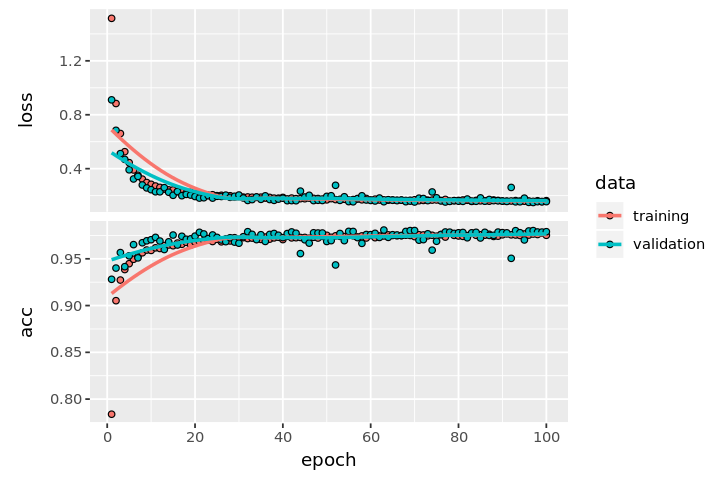

In [16]:
plot(history)

In [17]:
model %>% evaluate(X_test, y_test)

$loss
[1] 0.1472759

$acc
[1] 0.9807

## MNIST with convnet

In [18]:
mnist <- dataset_mnist()
c(c(X_train, y_train), c(X_test, y_test)) %<-% mnist

In [19]:
X_train <- array_reshape(X_train, c(60000, 28, 28, 1)) / 255
X_test <- array_reshape(X_test, c(10000, 28, 28, 1)) / 255

y_train <- to_categorical(y_train)
y_test <- to_categorical(y_test)

In [29]:
num_epochs <- 25
batch_size <- 256

model <- keras_model_sequential() %>%
    layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu", input_shape = c(28, 28, 1)) %>%
    layer_max_pooling_2d(pool_size = c(2, 2)) %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size = c(2, 2)) %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>%
    layer_flatten() %>%
    layer_dense(units = 64, activation = "relu", input_shape = c(28 * 28)) %>%
    layer_dense(units = 10, activation = "softmax")

model %>% compile(
    optimizer = optimizer_rmsprop(),
    loss = "categorical_crossentropy",
    metrics = "accuracy"
)
cat(summary(model))

history <- model %>% fit(
    X_train, y_train,
    epochs = num_epochs,
    batch_size = batch_size,
    validation_split = 0.2,
    callbacks = c(Progress$new(as.integer(0.8 * 60000 / batch_size), num_epochs, 10))
)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_10 (Conv2D)                  (None, 26, 26, 32)              320         
________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)      (None, 13, 13, 32)              0           
________________________________________________________________________________
conv2d_11 (Conv2D)                  (None, 11, 11, 64)              18496       
________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)      (None, 5, 5, 64)                0           
________________________________________________________________________________
conv2d_12 (Conv2D)                  (None, 3, 3, 64)                36928       
________________________________________________________________________________
flatten_4 (Flatten)         

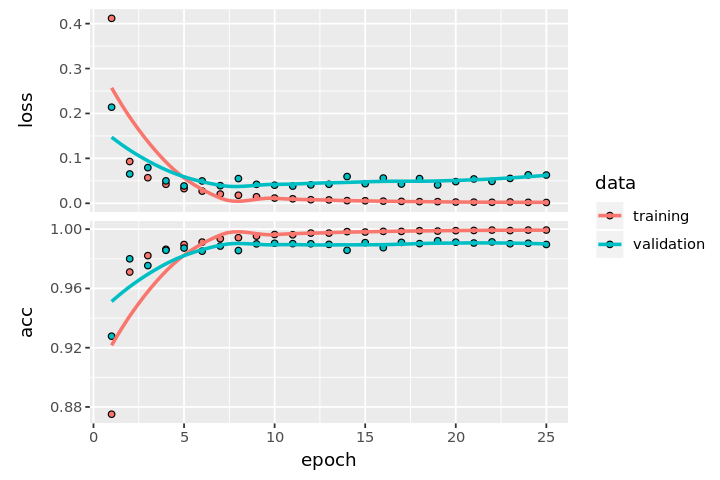

In [30]:
plot(history)

In [31]:
model %>% evaluate(X_test, y_test)

$loss
[1] 0.052472

$acc
[1] 0.9916

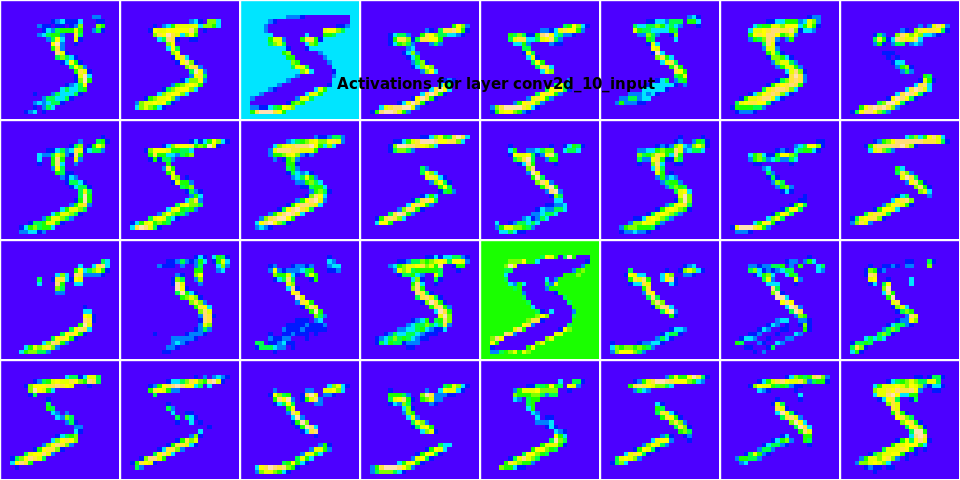

In [179]:
create_activation_model <- function(model) {
    is_conv_or_max_pool_layer <- function(layer) {
        name <- layer$name
        grepl('conv', name) || grepl('max_pooling', name)
    }

    layers <- Filter(is_conv_or_max_pool_layer, model$layers)
    layer_outputs <- lapply(layers, function(l) l$output)
    keras_model(inputs = model$input, outputs = layer_outputs)
}
                            
plot_activations <- function(activation_model, image) {
    plot_activation <- function(activation, num_cols = 8) {
        num_feature_maps <- dim(activation)[[4]]
        num_rows <- ceiling(num_feature_maps / num_cols)

        op <- par(mfrow = c(num_rows, num_cols), mai = rep_len(0.01, 4), oma = c(0, 0, 0, 0))
        options(repr.plot.width = 8, repr.plot.height = num_rows)

        for (i in 1:dim(activation)[[4]]) {
            row <- (i %/% num_cols)
            col <- i %% num_cols - 1

            image(t(apply(activation[1,,, i], 2, rev)), axes = FALSE, asp = 1, col = topo.colors(12))    
        }

        par(op)
    }
    
    # Format image
    
    input_shape <- append(c(1), unlist(activation_model$layers[[1]]$input_shape))
    image_reshaped <- array_reshape(image, input_shape)
    
    # Plot input image
    
#     plot(as.raster(image_reshaped[1,,,1]))
#     title("Input image", cex.main = 0.75)
    
    # Plot activations
    
    activations <- activation_model %>% predict(image_reshaped)
    plot_activation(activations[[1]])
    title(paste("Activations for layer", activation_model$layers[[1]]$name), cex.main = 0.75, line = -1)
}
                            
activation_model <- create_activation_model(model)
img_reshaped <- activation_model %>% plot_activations(X_train[1,,,])

In [150]:
activations <- activation_model %>% predict(img_reshaped)
glimpse(activations)

List of 5
 $ : num [1, 1:26, 1:26, 1:32] 0 0 0 0 0 0 0 0 0 0 ...
 $ : num [1, 1:13, 1:13, 1:32] 0 0 0 0 0 0 0 0 0 0 ...
 $ : num [1, 1:11, 1:11, 1:64] 0 0.00911 0.00622 0 0 ...
 $ : num [1, 1:5, 1:5, 1:64] 0.25439 0.00622 0 0 0.19554 ...
 $ : num [1, 1:3, 1:3, 1:64] 3.552 0 0 0.195 0 ...


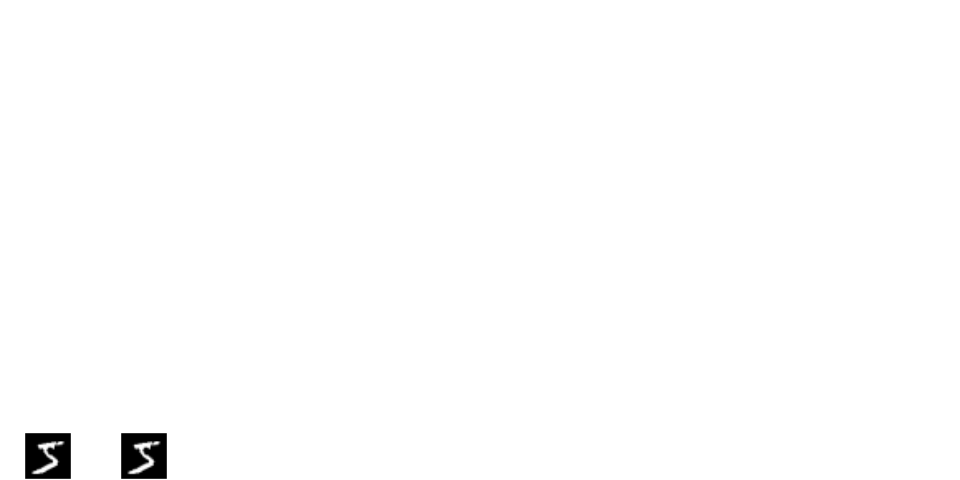

In [190]:
par(fig = c(0, 0.1, 0, 0.1), mai = rep_len(0.01, 4))
plot(as.raster(X_train[1,,,1]))

par(fig = c(0.1, 0.2, 0, 0.1), new = TRUE, mai = rep_len(0.01, 4))
plot(as.raster(X_train[1,,,1]))

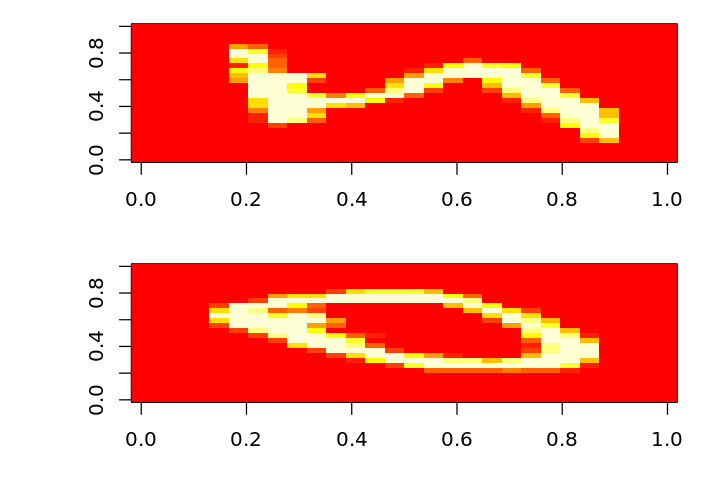

In [207]:
grid.arrange(grobs = list(as.ggplot(~image(X_train[1,,,1])), as.ggplot(~image(X_train[2,,,1]))))

In [210]:
glimpse(activations[[1]])

 num [1, 1:26, 1:26, 1:32] 0 0 0 0 0 0 0 0 0 0 ...


In [ ]:
options(repr.plot.width = 8, repr.plot.height = 4)

activation <- activations[[1]]
grobs <- list()
for (i in 1:dim(activation)[4]) {
    grobs[[i]] <- as.ggplot(~image(t(apply(activation[1,,, i], 2, rev)), axes = FALSE, asp = 1, col = topo.colors(12)))

    
#     if (i > 8)
#         grobs[[i]] <- grobs[[i]] + theme(plot.margin = unit(c(-1, -1, -1, -1), "pt"))
#     else
        grobs[[i]] <- grobs[[i]] + theme(plot.margin = unit(c(-25, -25, -15, -25), "pt"))
}

#

grid.arrange(grobs = grobs, nrow = 4, ncol = 8, top = "number bois", padding = unit(5, "cm"))
# grobs <- lapply(grobs, "+", theme(plot.margin = unit(c(0, 0, 0, 0), "cm")))

In [317]:
?grid.arrange

## Cats and dogs with convnets

In [221]:
train_datagen <- image_data_generator(rescale = 1 / 255)
val_datagen <- image_data_generator(rescale = 1 / 255)

In [222]:
train_generator <- flow_images_from_directory(
    '../cats-and-dogs/train/',
    train_datagen,
    target_size = c(100, 100),
    batch_size = 20,
    class_mode = "binary"
)

val_generator <- flow_images_from_directory(
    '../cats-and-dogs/val/',
    val_datagen,
    target_size = c(100, 100),
    batch_size = 20,
    class_mode = "binary"
)

In [223]:
glimpse(generator_next(train_generator)[[1]])

 num [1:20, 1:100, 1:100, 1:3] 0.412 0.925 0.251 0.231 0.843 ...


In [224]:
num_epochs <- 25
batch_size <- 256

model <- keras_model_sequential() %>%
    layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu", input_shape = c(100, 100, 3)) %>%
    layer_max_pooling_2d(pool_size = c(2, 2)) %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size = c(2, 2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size = c(2, 2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>%
    layer_flatten() %>%
    layer_dropout(rate = 0.5) %>%
    layer_dense(units = 64, activation = "relu") %>%
    layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
    optimizer = optimizer_rmsprop(lr = 0.0001),
    loss = "binary_crossentropy",
    metrics = c("acc")
)
cat(summary(model))

history <- model %>% fit_generator(
    train_generator,
    epochs = num_epochs,
    steps_per_epoch = 100,
    validation_data = val_generator,
    validation_steps = 50,
    callbacks = c(Progress$new(100, num_epochs, 10))
)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_13 (Conv2D)                  (None, 98, 98, 32)              896         
________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)      (None, 49, 49, 32)              0           
________________________________________________________________________________
conv2d_14 (Conv2D)                  (None, 47, 47, 64)              18496       
________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D)     (None, 23, 23, 64)              0           
________________________________________________________________________________
conv2d_15 (Conv2D)                  (None, 21, 21, 128)             73856       
________________________________________________________________________________
max_pooling2d_11 (MaxPooling

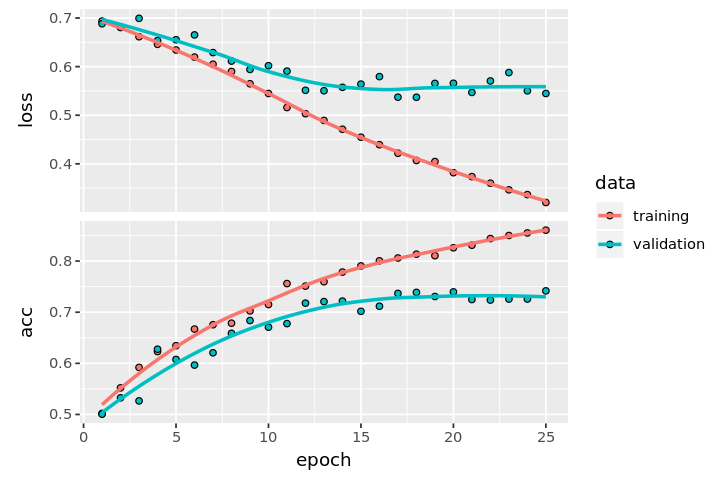

In [225]:
plot(history)

In [226]:
test_generator <- flow_images_from_directory(
    '../cats-and-dogs/test/',
    val_datagen,
    target_size = c(100, 100),
    batch_size = 20,
    class_mode = "binary"
)

model %>% evaluate_generator(test_generator, steps = 50)

$loss
[1] 0.5912961

$acc
[1] 0.714

## Data augmentation

In [280]:
train_datagen_augmented <- image_data_generator(
    rescale = 1 / 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = TRUE
)

train_generator_augmented <- flow_images_from_directory(
    '../cats-and-dogs/train/',
    train_datagen_augmented,
    target_size = c(100, 100),
    batch_size = 20,
    class_mode = "binary"
)

In [281]:
num_epochs <- 25
batch_size <- 128

model <- keras_model_sequential() %>%
    layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu", input_shape = c(100, 100, 3)) %>%
    layer_max_pooling_2d(pool_size = c(2, 2)) %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size = c(2, 2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size = c(2, 2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>%
    layer_flatten() %>%
    layer_dropout(rate = 0.5) %>%
    layer_dense(units = 64, activation = "relu") %>%
    layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
    optimizer = optimizer_rmsprop(lr = 0.0001),
    loss = "binary_crossentropy",
    metrics = c("acc")
)
cat(summary(model))

history <- model %>% fit_generator(
    train_generator_augmented,
    epochs = num_epochs,
    steps_per_epoch = 100,
    validation_data = val_generator,
    validation_steps = 50,
    callbacks = c(Progress$new(100, num_epochs, 10))
)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_17 (Conv2D)                  (None, 98, 98, 32)              896         
________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D)     (None, 49, 49, 32)              0           
________________________________________________________________________________
conv2d_18 (Conv2D)                  (None, 47, 47, 64)              18496       
________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D)     (None, 23, 23, 64)              0           
________________________________________________________________________________
conv2d_19 (Conv2D)                  (None, 21, 21, 128)             73856       
________________________________________________________________________________
max_pooling2d_14 (MaxPooling

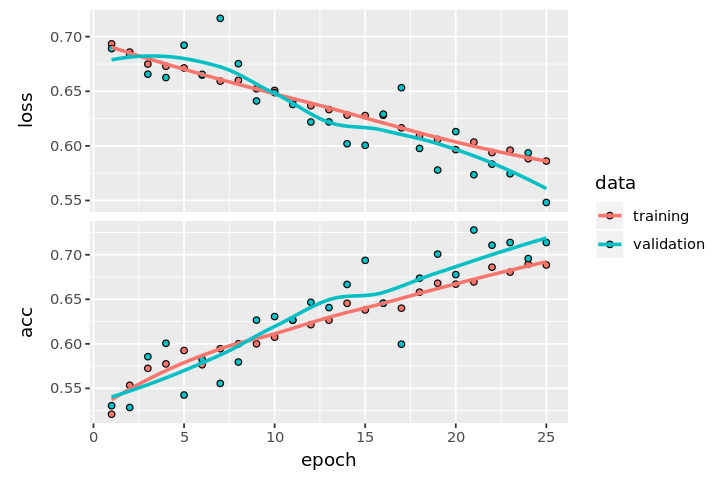

In [282]:
plot(history)

In [283]:
test_generator <- flow_images_from_directory(
    '../cats-and-dogs/test/',
    val_datagen,
    target_size = c(100, 100),
    batch_size = 20,
    class_mode = "binary"
)

model %>% evaluate_generator(test_generator, steps = 50)

$loss
[1] 0.5466016

$acc
[1] 0.708

## Visualization

In [ ]:
img <- image_load('../cats-and-dogs/test/cat/image-0010.jpg', target_size = c(100, 100))
img <- image_to_array(img)
img <- array_reshape(img, c(1, 100, 100, 3))
img <- img / 255
plot(as.raster(img[1,,,]))

In [ ]:
layer_outputs <- lapply(model$layers[1:7], function(l) l$output)
activation_model <- keras_model(inputs = model$input, outputs = layer_outputs)

In [ ]:
activations <- activation_model %>% predict(img)
glimpse(activations)

In [ ]:
image(t(apply(activations[[3]][1,,, 4], 2, rev)), axes = FALSE, asp = 1, col = topo.colors(12))

In [ ]:
activation <- activations[[1]]
dim(activation)

In [33]:
plot_activation <- function(activation, num_cols = 8) {
    num_feature_maps <- dim(activation)[[4]]
    num_rows <- ceiling(num_feature_maps / num_cols)
    
    op <- par(mfrow = c(num_rows, num_cols), mai = rep_len(0.01, 4))
    options(repr.plot.width = 8, repr.plot.height = num_rows)
    
    for (i in 1:dim(activation)[[4]]) {
        row <- (i %/% num_cols)
        col <- i %% num_cols - 1

        image(t(apply(activation[1,,, i], 2, rev)), axes = FALSE, asp = 1, col = topo.colors(12))    
    }

    par(op)
}

# plot_activation(activations[[1]])

In [ ]:
plot_activations <- function(model, input) {
    activations <- model %>% predict(input)
    num_layers <- length(activations)
    
    for (i in 1:num_layers) {
        plot_activation(activations[[i]])
        title(main = model$layers[[i]]$name, line = 1)
    }
}

plot_activations(activation_model, img)

## Pre-trained networks (VGGNet)

In [ ]:
conv_base <- application_vgg16(
    weights = "imagenet",
    include_top = FALSE,
    input_shape = c(100, 100, 3)
)
summary(conv_base)

In [ ]:
freeze_weights(conv_base)

In [ ]:
num_epochs <- 10\

model <- keras_model_sequential() %>%
    conv_base %>%
    layer_flatten() %>%
    layer_dense(units = 256, activation = "relu") %>%
    layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  loss = "binary_crossentropy",
  optimizer = optimizer_rmsprop(lr = 1e-5),
  metrics = c("accuracy")
)

cat(summary(model))

history <- model %>% fit_generator(
    train_generator,
    epochs = num_epochs,
    steps_per_epoch = 100,
    validation_data = val_generator,
    validation_steps = 50,
    callbacks = c(Progress$new(100, num_epochs, 10))
)

In [ ]:
plot(history)

In [ ]:
test_generator <- flow_images_from_directory(
    '../cats-and-dogs/test/',
    val_datagen,
    target_size = c(100, 100),
    batch_size = 20,
    class_mode = "binary"
)

model %>% evaluate_generator(test_generator, steps = 50)